In [1]:
import icecube
from I3Tray import *
from icecube import icetray, dataio, dataclasses, photonics_service, DomTools
from icecube import tableio, hdfwriter
import copy,math
import numpy as np
import tables
from icecube.hdfwriter import I3HDFWriter
import matplotlib as mpl
import pylab
import matplotlib.pyplot as plt
from os.path import expandvars
import sys, os
import glob
from icecube import NewNuFlux
from icecube.icetray import I3Units
import matplotlib.gridspec as gridspec
import pickle
from scipy.optimize import curve_fit

from icecube.weighting.fluxes import Hoerandel5,GaisserH3a
from icecube.weighting import weighting

conventional = NewNuFlux.makeFlux("honda2006")
conventional.knee_reweighting_model = "gaisserH3a_elbert"

sys.path.append('/data/user/kevin/softwares/IceCubeMinDist')
import ICMinDist

sys.path.append("/home/kevin/softwares/")
import dashi
dashi.visual()

In [2]:
%matplotlib inline

"Millipde" gives energy losses along the event track.
There are one event per frame.

In [3]:
def get_millipede_energy_data(Frame, starting_cut=False):
    """
    Getting millipede energy losses for each frame
    starting_cut: True for muon events (i.e. strarting tracks)
        and False for through-going muon events
    returns: Total_Time, Total_Released_Energy, AccumulatedEnergy(array),
        AccumulatedEnergy_Percentile(array), CascadeEnergy,
        min_dist_of_cascade, IsStarting
    """
    if('MillipedeHighEnergy' not in frame.keys()):
        return [], [], [], [], 0, 1000, False
    Millipede_ = frame['MillipedeHighEnergy']
    Time_ = []
    Energy_ = []
    AccumulatedEnergy_ = []
    AccumulatedEnergy_Percentile_ = []
    CascadeEnergy_ = 0.0
    j_0 = 0  # begining of sequence
    j_1 = 0  # end of sequence

    # find begining of track
    for i in range(len(Millipede_)):
        if(Millipede_[i].energy > 0.0):
            if(ICMinDist.minDistDet(Millipede_[i].pos.x,
                                    Millipede_[i].pos.y,
                                    Millipede_[i].pos.z) <= 0):
                j_0 = i
                IsStarting_ = True
                mc_ = ICMinDist.minDistDet(Millipede_[i].pos.x,
                                           Millipede_[i].pos.y,
                                           Millipede_[i].pos.z)
                break

            j_0 = i
            IsStarting_ = False
            mc_ = 1000
            break

    # find end of track
    for i in range(j_0, len(Millipede_)):
        if(ICMinDist.minDistDet(Millipede_[i].pos.x,
                                Millipede_[i].pos.y,
                                Millipede_[i].pos.z) >= 0):
            j_1 = i
            break

    # get cascade energy
    if(IsStarting_):
        for i in range(j_0, min(j_0 + 3, j_1)):
            CascadeEnergy_ += Millipede_[i].energy

    # will remove the cascade part (3x10m or define distance)
    if(starting_cut):
        if(IsStarting_):
            j_0 += 3

    # if track length is zero
    if(j_0 >= j_1):
        return Time_, Energy_, AccumulatedEnergy_, AccumulatedEnergy_Percentile_, CascadeEnergy_, mc_, False

    for i in range(j_0, j_1):
        Time_.append(Millipede_[i].time)
        Energy_.append(Millipede_[i].energy)
        AccumulatedEnergy_.append(sum(Energy_))

    for i in range(100):
        AccumulatedEnergy_Percentile_.append(
            np.percentile(AccumulatedEnergy_, i))

    return Time_, Energy_, AccumulatedEnergy_, AccumulatedEnergy_Percentile_, CascadeEnergy_, mc_, IsStarting_

In [4]:
# just an array of percentiles
# default from 0 to 100 (excluding 100) every 0.01
PercentileX = []
PERCENTILE_SIZE = 100
for i in range(PERCENTILE_SIZE):
    PercentileX.append(i * 1. / PERCENTILE_SIZE)

IceCube data are saved on ".i3" files which is iterable on frames and each frame contians a dictionary which includes events' info.

In [5]:
# Opening .i3 file
inFile = dataio.I3File('/data/ana/SterileNeutrino/IC86/startingTracks/data/2012/12560/L4/0000000-0000999/Level4_IC86.2012_nugen_numu_000000.i3.bz2')

Going along the track and ploting the CDF of the energy losses. These data (among other things) will be used for neurino energy reconstruction.

(861.963994675608, 1834.6025235897923, 1956.28109200238)
(159.8310700042303, 2334.9486663870084, 110.06434490903453)
(550.5499338806334, 1501.0384283916483, 100.86158372010314)
(734.9672434190371, 2435.0178949464516, 134.06293331383492)
(542.861189754496, 3569.1358186201414, 74.19407977371165)
(152.29954519019626, 2468.374304466266, 21.816520605080502)
(149.30450763688017, 1634.464066470906, 42.92532582412911)
(1202.7148438823078, 2368.305075906823, 248.25397702680303)
(75.46961100387226, 2401.6614854266372, 24.53456814415298)
(333.47225421155923, 1134.1179236736898, 208.7762219431392)


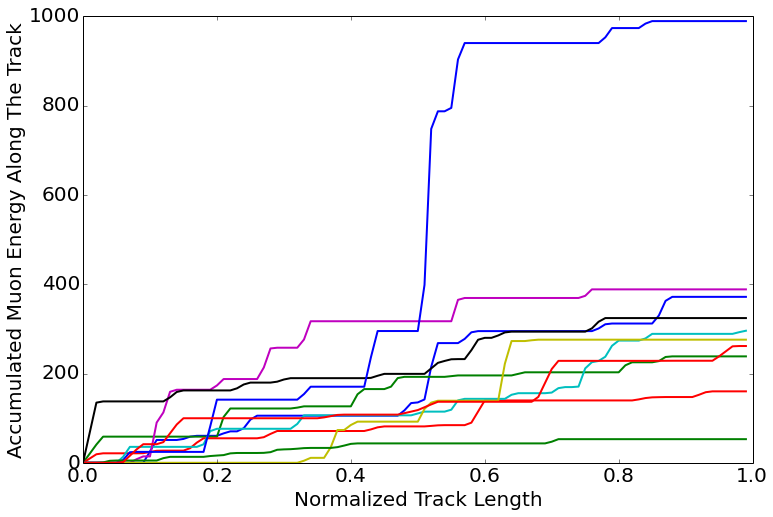

In [7]:
# Only for visualisation 
fig = plt.figure(figsize=(12, 8))

inFile.rewind()
j = 0
while(inFile.more()):
    frame = inFile.pop_physics()
    Time, Energy, AccumulatedEnergy, AccumulatedEnergy_Percentile, CascadeEnergy, mc, IsStarting = get_millipede_energy_data(
        frame, starting_cut=True)
    if(IsStarting):
        plt.plot(PercentileX, AccumulatedEnergy_Percentile, linewidth=2)
        print(dataclasses.get_most_energetic_muon(frame['I3MCTree']).energy, Time[-1] - Time[0],
              CascadeEnergy)
        j += 1
    if(j > 9):
        break

plt.legend(fontsize=20, loc=4)
plt.xlabel('Normalized Track Length', fontsize=20)
plt.ylabel('Accumulated Muon Energy Along The Track', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [8]:
# Closing the file.
inFile.close()

Using scikit-learn regressor for neutrino energy reconstruction.

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib
import glob

Loading data from the files intp numpy arrays.

In [40]:
# nfiles and nEvents are number of files and number of events
# per file in the simulations which will be necessary to properly
# weight the events.
nfiles=999
nEvents=50000

j = 0
for file in glob.glob('/data/ana/SterileNeutrino/IC86/startingTracks/data/2012/12560/L4/0000000-0000999/Level4_IC86.2012_nugen_numu_*.i3.bz2'):
    inFile = dataio.I3File(file)
    while(inFile.more()):
        frame=inFile.pop_physics()
        if(frame!=None):
            Time,AccumulatedEnergy_Percentile,CascadeEnergy,mc_,Status = get_millipede_energy_data_short(frame, starting_cut=True)
            if((mc_<-f(CascadeEnergy))&(dataclasses.get_most_energetic_muon(frame['I3MCTree'])!=None)&Status):
                X_=AccumulatedEnergy_Percentile
                X_.append(Time[-1]-Time[0])
                X_.append(CascadeEnergy)
                y_ = dataclasses.get_most_energetic_muon(frame['I3MCTree']).energy
                pt_ = dataclasses.get_most_energetic_cascade(frame['I3MCTree']).pos
                mt_ = ICMinDist.minDistDet(pt_.x,pt_.y,pt_.z)
                icecube.weighting.get_weighted_primary(frame,MCPrimary='prime')
                En_ = frame['prime'].energy
                Zen_ = frame['prime'].dir.zenith
                Type_ = frame['prime'].type
                OW_ = frame['I3MCWeightDict']['OneWeight']
                weight_ = np.divide(conventional.getFlux(np.int32(Type_),En_,np.cos(Zen_)),
                           (0.5*nEvents*nfiles))
                w_=np.multiply(weight_,OW_)
                if(j==0):
                    X = np.copy(X_)
                    y = np.copy(y_)
                    mc = np.copy(mc_)
                    mt = np.copy(mt_)
                    w = np.copy(w_)
                else:
                    X = np.column_stack((X, X_))
                    y = np.column_stack((y, y_))
                    mc = np.column_stack((mc, mc_))
                    mt = np.column_stack((mt, mt_))
                    w = np.column_stack((w, w_))
                j += 1
    inFile.close()

Saving them in pickle files for convenience.

In [9]:
import pickle

In [10]:
# Comment out to avoid accidental overwriting.

'''pickle.dump( X, open( "12560_X.p", "wb" ) )
pickle.dump( y, open( "12560_y.p", "wb" ) )
pickle.dump( mc, open( "12560_mc.p", "wb" ) )
pickle.dump( mt, open( "12560_mt.p", "wb" ) )
pickle.dump( w, open( "12560_w.p", "wb" ) )'''

'pickle.dump( X, open( "12560_X.p", "wb" ) )\npickle.dump( y, open( "12560_y.p", "wb" ) )\npickle.dump( mc, open( "12560_mc.p", "wb" ) )\npickle.dump( mt, open( "12560_mt.p", "wb" ) )\npickle.dump( w, open( "12560_w.p", "wb" ) )'

In [11]:
# Load data from pickle files

X = pickle.load( open( '12560_X.p', "rb" ) )
y = pickle.load( open( '12560_y.p', "rb" ) )
mc = pickle.load( open( '12560_mc.p', "rb" ) )
mt = pickle.load( open( '12560_mt.p', "rb" ) )
w = pickle.load( open( '12560_w.p', "rb" ) )

Calculating dE/dx (energy per length) is one of the varibale which is directly correlated to the energy of muons.

In [12]:
# Calculating dE/dx
for i in range(len(X[-3,:])):
    if(X[-2,i]>0):
        dEdx_ = np.divide(X[-3,i],X[-2,i]*0.299792458)
    else:
        dEdx_ = 0.0
    if(i==0):
        dEdx = np.array([dEdx_])
    else:
        dEdx = np.append(dEdx,dEdx_)

In [13]:
# Stack them onto X
X=np.row_stack((X,dEdx))

In [14]:
# Transpose all the variables
X=X.T
y=y.T
mc=mc.T
mt=mt.T
w=w.T

Traing should be done on 90% of the events (due to limited statistics of the simulation) and 10% of testing.

*Since training will be done on a different simulation set (NuGen) than the dataset that analysis will be done on (NuFSGen), splitting will not be necessary for the final run. This will give us more data to train on.

*NuGen is more comprehensive ergo the trainings should be done using them. NuFSGen has more statistics and extra information about the events which is necessary for the final analysis.

In [18]:
# Not needed for final run*
# Splitind data into train/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1,random_state=42)
mc_train, mc_test, mt_train, mt_test, w_train, w_test = train_test_split(mc, mt, w, test_size=.1,random_state=42)

In [19]:
# shape of X
print(np.row_stack((X[0].T,X[1].T)).T.shape)

(103, 2)


Running the fit:

In [485]:
rng = np.random.RandomState(1)

regr = AdaBoostRegressor(DecisionTreeRegressor(),
                          n_estimators=30, random_state=rng)

regr.fit(X, y,sample_weight=w)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=30,
         random_state=<mtrand.RandomState object at 0x602d1768>)

In [511]:
# dumping info
# joblib.dump(regr_7, 'nuEn/regr/regr_12560_weighted_unFiltered_30.pkl')

['nuEn/regr/regr_12560_weighted_unFiltered_30.pkl',
 'nuEn/regr/regr_12560_weighted_unFiltered_30.pkl_01.npy',
 'nuEn/regr/regr_12560_weighted_unFiltered_30.pkl_02.npy',
 'nuEn/regr/regr_12560_weighted_unFiltered_30.pkl_03.npy',
 'nuEn/regr/regr_12560_weighted_unFiltered_30.pkl_04.npy',
 'nuEn/regr/regr_12560_weighted_unFiltered_30.pkl_05.npy',
 'nuEn/regr/regr_12560_weighted_unFiltered_30.pkl_06.npy']

Redining "get_millipede_energy_data" for faster processing:

In [20]:
def get_millipede_energy_data_short(Frame, starting_cut=False):
    if('MillipedeHighEnergy' not  in frame.keys()):
        return [], [], 0, 1000, False
    Millipede_ = frame['MillipedeHighEnergy']
    Time_ = []
    Energy_ = []
    AccumulatedEnergy_ = []
    AccumulatedEnergy_Percentile_ = []
    CascadeEnergy_ = 0.0
    j_0 = 0 #begining of sequence
    j_1 = 0 #end of sequence
    
    #find begining of track
    for i in range(len(Millipede_)):
        if(Millipede_[i].energy>0.0):
            if(ICMinDist.minDistDet(Millipede_[i].pos.x,
                                    Millipede_[i].pos.y,
                                    Millipede_[i].pos.z) <= 0):
                j_0 = i
                IsStarting_ = True
                mc_ = ICMinDist.minDistDet(Millipede_[i].pos.x,
                                           Millipede_[i].pos.y,
                                           Millipede_[i].pos.z)
                break
                
            j_0 = i
            IsStarting_= False
            mc_ = 1000
            break
    
    #find end of track
    for i in range(j_0, len(Millipede_)):
        if(ICMinDist.minDistDet(Millipede_[i].pos.x,
                                Millipede_[i].pos.y,
                                Millipede_[i].pos.z) >= 0):
            j_1 = i
            break

    #get cascade energy
    if(IsStarting_):
        for i in range(j_0, min(j_0+3,j_1)):
            CascadeEnergy_ += Millipede_[i].energy
    
    #will remove the cascade part (3x10m or define distance)
    if(starting_cut):
        if(IsStarting_):
            j_0 += 3
    
    #if track length is zero
    if(j_0 >= j_1):
        return [], [], CascadeEnergy_, mc_, False
    
    
    for i in range(j_0, j_1):
        Time_.append(Millipede_[i].time)
        Energy_.append(Millipede_[i].energy)
        AccumulatedEnergy_.append(sum(Energy_))
        
    for i in range(100):
        AccumulatedEnergy_Percentile_.append(np.percentile(AccumulatedEnergy_,i))
    
    return  Time_, AccumulatedEnergy_Percentile_, CascadeEnergy_, mc_, True

Looking at the results of the machie learning in "EnRecResult.ipynb".